In [1]:
from finders.data_finders import find_dirs_mit_bih
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import wfdb
from collections import Counter
import warnings
import logging

warnings.filterwarnings("ignore")

# Настройка логирования
logging.basicConfig(level=logging.INFO, format="%(levelname)s: %(message)s")

# Настройка стиля графиков
plt.style.use("seaborn-v0_8-darkgrid")
plt.rcParams["figure.figsize"] = [12, 6]
plt.rcParams["figure.dpi"] = 100

In [2]:
# Получение путей к данным
def get_mitbih_paths():
    """
    Получает пути к MIT-BIH данным с использованием функции find_dirs_mit_bih
    """
    print("=" * 60)
    print("ПОЛУЧЕНИЕ ПУТЕЙ К ДАННЫМ MIT-BIH")
    print("=" * 60)

    try:
        # Получаем корневую директорию проекта
        current_dir = Path.cwd()

        # Ищем корень проекта по наличию key directories
        project_root = None
        for parent in [current_dir] + list(current_dir.parents):
            if (parent / "data").exists() and (parent / "plots").exists():
                project_root = parent
                break

        if project_root is None:
            project_root = current_dir
            print(
                f"⚠ Корень проекта не найден, используем текущую директорию: {project_root}"
            )
        else:
            print(f"✓ Корень проекта найден: {project_root}")

        # Получаем пути к директориям MIT-BIH
        mit_bih_dir, x_mitdb_dir = find_dirs_mit_bih(project_root)

        print(f"✓ Основная директория MIT-BIH: {mit_bih_dir}")
        print(f"✓ Директория x_mitdb: {x_mitdb_dir}")

        return mit_bih_dir, x_mitdb_dir

    except FileNotFoundError as e:
        print(f"❌ Ошибка: {e}")
        exit()
    except Exception as e:
        print(f"❌ Произошла ошибка при получении путей: {e}")
        import traceback

        traceback.print_exc()
        exit()


def load_annotations_from_file(file_path):
    """
    Загружает аннотации из файла .atr

    Parameters:
    -----------
    file_path : Path
        Путь к файлу аннотаций

    Returns:
    --------
    tuple : (samples, symbols, annotation_object) или None в случае ошибки
    """
    try:
        # Загружаем аннотации через wfdb
        ann = wfdb.rdann(str(file_path.with_suffix("")), extension="atr")

        # Извлекаем символы и сэмплы
        symbols = np.array(ann.symbol)
        samples = np.array(ann.sample)

        return samples, symbols, ann

    except Exception as e:
        print(f"  Ошибка при загрузке {file_path.name}: {e}")
        return None


def find_and_load_all_annotations():
    """
    Находит и загружает все аннотации из обеих папок
    с исключением дубликатов (приоритет x_mitdb)

    Returns:
    --------
    dict: словарь со всей статистикой
    """
    print("\n" + "=" * 60)
    print("ПОИСК И ЗАГРУЗКА ВСЕХ АННОТАЦИЙ")
    print("=" * 60)

    # Словари для хранения данных
    x_mitdb_records = {}  # Записи из x_mitdb
    original_records = {}  # Оригинальные записи
    final_records = {}  # Итоговый набор без дубликатов

    # 1. Загружаем ВСЕ записи из x_mitdb
    print("\n1. ЗАГРУЗКА ВСЕХ ЗАПИСЕЙ ИЗ X_MITDB:")
    print("-" * 50)

    x_files = list(X_MITDB_PATH.glob("*.atr"))
    print(f"Найдено файлов в x_mitdb: {len(x_files)}")

    for atr_file in x_files:
        record_name = atr_file.stem
        clean_name = record_name[2:] if record_name.startswith("x_") else record_name

        print(f"\n  Загрузка {record_name} (ориг. {clean_name}):", end=" ")
        result = load_annotations_from_file(atr_file)

        if result is None:
            print("ОШИБКА")
            continue

        samples, symbols, ann = result
        symbol_counts = Counter(symbols)

        x_mitdb_records[clean_name] = {
            "record_name": record_name,
            "clean_name": clean_name,
            "source": "x_mitdb",
            "total_annotations": len(symbols),
            "symbol_counts": dict(symbol_counts),
            "unique_symbols": list(symbol_counts.keys()),
            "samples": samples,
            "symbols": symbols,
            "ann_object": ann,
        }

        # Добавляем в итоговый набор (приоритет x_mitdb)
        final_records[clean_name] = {
            "record_name": clean_name,
            "source": "x_mitdb",
            "total_annotations": len(symbols),
            "symbol_counts": dict(symbol_counts),
            "unique_symbols": list(symbol_counts.keys()),
            "samples": samples,
            "symbols": symbols,
        }

        print(f"✓ {len(symbols)} аннотаций")

    print(f"\n✓ Загружено записей из x_mitdb: {len(x_mitdb_records)}")

    # 2. Загружаем оригинальные записи, КРОМЕ тех, что уже есть в x_mitdb
    print("\n\n2. ЗАГРУЗКА ОРИГИНАЛЬНЫХ ЗАПИСЕЙ (БЕЗ ДУБЛИКАТОВ):")
    print("-" * 50)

    original_files = list(BASE_PATH.glob("*.atr"))
    print(f"Найдено файлов в основной папке: {len(original_files)}")

    skipped_due_to_xmitdb = 0
    loaded_originals = 0

    for atr_file in original_files:
        record_name = atr_file.stem

        # Пропускаем нечисловые имена (например, файлы с другими расширениями)
        if not record_name.isdigit():
            continue

        # Если эта запись уже есть в x_mitdb, пропускаем ее
        if record_name in x_mitdb_records:
            skipped_due_to_xmitdb += 1
            continue

        print(f"\n  Загрузка оригинальной записи {record_name}:", end=" ")
        result = load_annotations_from_file(atr_file)

        if result is None:
            print("ОШИБКА")
            continue

        samples, symbols, ann = result
        symbol_counts = Counter(symbols)

        original_records[record_name] = {
            "record_name": record_name,
            "source": "original",
            "total_annotations": len(symbols),
            "symbol_counts": dict(symbol_counts),
            "unique_symbols": list(symbol_counts.keys()),
            "samples": samples,
            "symbols": symbols,
            "ann_object": ann,
        }

        # Добавляем в итоговый набор
        final_records[record_name] = {
            "record_name": record_name,
            "source": "original",
            "total_annotations": len(symbols),
            "symbol_counts": dict(symbol_counts),
            "unique_symbols": list(symbol_counts.keys()),
            "samples": samples,
            "symbols": symbols,
        }

        loaded_originals += 1
        print(f"✓ {len(symbols)} аннотаций")

    print(f"\n✓ Загружено оригинальных записей: {loaded_originals}")
    print(f"✓ Пропущено записей (есть в x_mitdb): {skipped_due_to_xmitdb}")

    # 3. Подсчитываем общую статистику
    print("\n\n3. ПОДСЧЕТ ОБЩЕЙ СТАТИСТИКИ:")
    print("-" * 50)

    # Собираем все символы из итогового набора
    all_symbols = []
    for record_data in final_records.values():
        all_symbols.extend(record_data["symbols"])

    total_counter = Counter(all_symbols)

    # Статистика по источникам
    source_counts = {"x_mitdb": 0, "original": 0}
    source_annotations = {"x_mitdb": 0, "original": 0}

    for record_data in final_records.values():
        source = record_data["source"]
        source_counts[source] += 1
        source_annotations[source] += record_data["total_annotations"]

    # Формируем итоговую структуру
    final_stats = {
        "x_mitdb_records": x_mitdb_records,
        "original_records": original_records,
        "final_records": final_records,
        "all_symbols": all_symbols,
        "total_counter": dict(total_counter),
        "total_annotations": len(all_symbols),
        "unique_symbols_total": len(total_counter),
        "source_counts": source_counts,
        "source_annotations": source_annotations,
        "total_records": len(final_records),
    }

    # Выводим сводку
    print("\nИТОГОВАЯ СВОДКА:")
    print(f"  Всего уникальных записей: {len(final_records)}")
    print(f"    - из x_mitdb: {source_counts['x_mitdb']} записей")
    print(f"    - оригинальных: {source_counts['original']} записей")
    print(f"  Всего аннотаций: {len(all_symbols):,}")
    print(f"    - из x_mitdb: {source_annotations['x_mitdb']:,} аннотаций")
    print(f"    - оригинальных: {source_annotations['original']:,} аннотаций")
    print(f"  Уникальных типов аннотаций: {len(total_counter)}")

    # Топ-5 символов
    top5 = total_counter.most_common(5)
    print("\n  Топ-5 самых частых символов:")
    for i, (sym, cnt) in enumerate(top5, 1):
        percentage = cnt / len(all_symbols) * 100
        print(f"    {i}. '{sym}': {cnt:,} ({percentage:.1f}%)")

    return final_stats


def plot_final_statistics(stats):
    """
    Строит графики итоговой статистики (объединенный набор без дубликатов)
    """
    if not stats["all_symbols"]:
        print("Нет данных для визуализации")
        return

    total_counter = stats["total_counter"]
    total_annotations = stats["total_annotations"]

    # Сортировка по количеству
    symbols = list(total_counter.keys())
    counts = list(total_counter.values())

    sorted_idx = np.argsort(counts)[::-1]
    symbols = [symbols[i] for i in sorted_idx]
    counts = [counts[i] for i in sorted_idx]

    # Создаем фигуру с подграфиками
    fig = plt.figure(figsize=(16, 12))

    # 1. Основная столбчатая диаграмма (топ-20 символов)
    ax1 = plt.subplot(3, 2, 1)
    top_n = min(20, len(symbols))
    bars = ax1.bar(
        symbols[:top_n], counts[:top_n], color=plt.cm.tab20c(np.arange(top_n) / top_n)
    )

    ax1.set_xlabel("Символ аннотации", fontsize=12, fontweight="bold")
    ax1.set_ylabel("Количество событий", fontsize=12, fontweight="bold")
    ax1.set_title(
        f"Топ-{top_n} символов в объединенном наборе\n({total_annotations:,} аннотаций)",
        fontsize=14,
        fontweight="bold",
        pad=15,
    )
    ax1.tick_params(axis="x", rotation=45)

    # Добавляем значения на столбцы
    for bar, count in zip(bars, counts[:top_n]):
        height = bar.get_height()
        ax1.text(
            bar.get_x() + bar.get_width() / 2.0,
            height + max(counts[:top_n]) * 0.01,
            f"{count:,}",
            ha="center",
            va="bottom",
            fontsize=8,
            fontweight="bold",
        )

    # 2. Круговая диаграмма (с группировкой)
    ax2 = plt.subplot(3, 2, 2)

    # Группируем редкие символы (менее 0.3%)
    threshold = total_annotations * 0.003
    main_counts = []
    main_labels = []
    other_count = 0
    other_symbols = []

    for sym, cnt in zip(symbols, counts):
        if cnt >= threshold:
            main_counts.append(cnt)
            main_labels.append(f"{sym}")
        else:
            other_count += cnt
            other_symbols.append(sym)

    if other_count > 0:
        main_counts.append(other_count)
        main_labels.append(f"Прочие\n({len(other_symbols)} симв.)")

    colors = plt.cm.Set3(np.arange(len(main_counts)) / len(main_counts))
    wedges, texts, autotexts = ax2.pie(
        main_counts,
        labels=main_labels,
        autopct="%1.1f%%",
        colors=colors,
        startangle=90,
        textprops={"fontsize": 8, "fontweight": "bold"},
    )

    # Увеличиваем размер текста для процентов
    for autotext in autotexts:
        autotext.set_fontsize(9)
        autotext.set_fontweight("bold")

    ax2.set_title(
        "Распределение аннотаций в объединенном наборе",
        fontsize=14,
        fontweight="bold",
        pad=15,
    )

    # 3. Распределение записей по источникам
    ax3 = plt.subplot(3, 2, 3)

    sources = ["x_mitdb\n(исправленные)", "Оригинальные\n(не переаннотированные)"]
    record_counts = [
        stats["source_counts"]["x_mitdb"],
        stats["source_counts"]["original"],
    ]

    bars3 = ax3.bar(sources, record_counts, color=["#e74c3c", "#3498db"])
    ax3.set_xlabel("Источник данных", fontsize=12, fontweight="bold")
    ax3.set_ylabel("Количество записей", fontsize=12, fontweight="bold")
    ax3.set_title(
        "Количество записей по источникам", fontsize=14, fontweight="bold", pad=15
    )

    for bar, count in zip(bars3, record_counts):
        ax3.text(
            bar.get_x() + bar.get_width() / 2.0,
            bar.get_height() + max(record_counts) * 0.01,
            f"{count}",
            ha="center",
            va="bottom",
            fontsize=11,
            fontweight="bold",
        )

    # 4. Распределение аннотаций по источникам
    ax4 = plt.subplot(3, 2, 4)

    annotation_counts = [
        stats["source_annotations"]["x_mitdb"],
        stats["source_annotations"]["original"],
    ]

    bars4 = ax4.bar(sources, annotation_counts, color=["#e74c3c", "#3498db"])
    ax4.set_xlabel("Источник данных", fontsize=12, fontweight="bold")
    ax4.set_ylabel("Количество аннотаций", fontsize=12, fontweight="bold")
    ax4.set_title(
        "Количество аннотаций по источникам", fontsize=14, fontweight="bold", pad=15
    )

    for bar, count in zip(bars4, annotation_counts):
        ax4.text(
            bar.get_x() + bar.get_width() / 2.0,
            bar.get_height() + max(annotation_counts) * 0.01,
            f"{count:,}",
            ha="center",
            va="bottom",
            fontsize=11,
            fontweight="bold",
        )

    # 5. Распределение количества аннотаций по записям
    ax5 = plt.subplot(3, 2, 5)

    # Собираем данные по записям
    record_names = []
    annotation_counts_per_record = []

    for record_name, record_data in sorted(
        stats["final_records"].items(),
        key=lambda x: x[1]["total_annotations"],
        reverse=True,
    )[:15]:  # Топ-15 записей
        record_names.append(
            f"{record_name}\n({record_data['source'][0]})"
        )  # 'x' или 'o'
        annotation_counts_per_record.append(record_data["total_annotations"])

    bars5 = ax5.bar(
        record_names,
        annotation_counts_per_record,
        color=plt.cm.viridis(np.arange(len(record_names)) / len(record_names)),
    )

    ax5.set_xlabel(
        "Запись (источник: x=исправленная, o=оригинальная)",
        fontsize=11,
        fontweight="bold",
    )
    ax5.set_ylabel("Количество аннотаций", fontsize=12, fontweight="bold")
    ax5.set_title(
        "Топ-15 записей по количеству аннотаций", fontsize=14, fontweight="bold", pad=15
    )
    ax5.tick_params(axis="x", rotation=45)

    for bar, count in zip(bars5, annotation_counts_per_record):
        ax5.text(
            bar.get_x() + bar.get_width() / 2.0,
            bar.get_height() + max(annotation_counts_per_record) * 0.01,
            f"{count:,}",
            ha="center",
            va="bottom",
            fontsize=8,
            fontweight="bold",
        )

    # 6. Таблица с топ-символами
    ax6 = plt.subplot(3, 2, 6)
    ax6.axis("tight")
    ax6.axis("off")

    # Описание символов MIT-BIH
    symbol_descriptions = {
        "N": "Normal beat",
        "V": "Premature ventricular",
        "S": "Supraventricular",
        "F": "Fusion beat",
        "/": "Paced beat",
        "A": "Atrial premature",
        "L": "Left BBB",
        "R": "Right BBB",
        "Q": "Unclassifiable",
        "E": "Ventricular escape",
        "J": "Junctional escape",
        "a": "Aberrated atrial",
        "e": "Atrial escape",
        "j": "Nodal escape",
    }

    # Собираем данные для таблицы (топ-12)
    table_data = []
    for i, (sym, cnt) in enumerate(zip(symbols[:12], counts[:12])):
        desc = symbol_descriptions.get(sym, "Other")
        percentage = cnt / total_annotations * 100
        table_data.append([i + 1, sym, f"{cnt:,}", f"{percentage:.1f}%", desc])

    # Создаем таблицу
    table = ax6.table(
        cellText=table_data,
        colLabels=["№", "Символ", "Кол-во", "Доля", "Описание"],
        cellLoc="center",
        loc="center",
        colWidths=[0.05, 0.08, 0.15, 0.1, 0.25],
    )

    table.auto_set_font_size(False)
    table.set_fontsize(8)
    table.scale(1, 1.8)

    # Выделяем заголовки
    for i in range(5):
        table[(0, i)].set_facecolor("#2c3e50")
        table[(0, i)].set_text_props(weight="bold", color="white", fontsize=9)

    # Альтернативная цветовая схема для строк
    for i in range(1, len(table_data) + 1):
        if i % 2 == 0:
            for j in range(5):
                table[(i, j)].set_facecolor("#f8f9fa")

    plt.suptitle(
        "СТАТИСТИКА ОБЪЕДИНЕННОГО НАБОРА MIT-BIH (БЕЗ ДУБЛИКАТОВ)",
        fontsize=18,
        fontweight="bold",
        y=1.02,
    )
    plt.tight_layout()
    plt.show()

    # Выводим детальную статистику
    print("\n" + "=" * 80)
    print("ДЕТАЛЬНАЯ СТАТИСТИКА ОБЪЕДИНЕННОГО НАБОРА:")
    print("=" * 80)

    print("\nОБЩАЯ СТАТИСТИКА:")
    print(f"  Всего уникальных записей: {stats['total_records']}")
    print(f"    • Исправленные (x_mitdb): {stats['source_counts']['x_mitdb']} записей")
    print(f"    • Оригинальные: {stats['source_counts']['original']} записей")
    print(f"  Всего аннотаций: {stats['total_annotations']:,}")
    print(f"    • Из исправленных записей: {stats['source_annotations']['x_mitdb']:,}")
    print(f"    • Из оригинальных записей: {stats['source_annotations']['original']:,}")
    print(f"  Уникальных типов аннотаций: {stats['unique_symbols_total']}")

    # Список исправленных записей
    print("\nИСПРАВЛЕННЫЕ ЗАПИСИ (из x_mitdb):")
    x_records = list(stats["x_mitdb_records"].keys())
    x_records.sort()
    print(f"  Всего: {len(x_records)} записей")
    print(f"  Список: {', '.join(x_records)}")

    # Топ-символы
    print("\nТОП-15 САМЫХ ЧАСТЫХ СИМВОЛОВ:")
    print("-" * 60)
    print(f"{'№':<3} {'Символ':<6} {'Количество':<12} {'Доля':<8} {'Накоп. доля':<12}")
    print("-" * 60)

    cumulative = 0
    for i, (sym, cnt) in enumerate(zip(symbols[:15], counts[:15]), 1):
        percentage = cnt / total_annotations * 100
        cumulative += percentage
        print(f"{i:<3} {sym:<6} {cnt:<12,} {percentage:>6.1f}% {cumulative:>11.1f}%")

    # Группировка по категориям AAMI
    print("\nГРУППИРОВКА ПО КАТЕГОРИЯМ AAMI:")
    print("-" * 60)

    aami_mapping = {
        "N": "N",
        "L": "N",
        "R": "N",
        "e": "N",
        "j": "N",  # Normal
        "A": "S",
        "a": "S",
        "S": "S",
        "J": "S",  # Supraventricular
        "V": "V",
        "E": "V",  # Ventricular
        "F": "F",  # Fusion
        "/": "Q",
        "f": "Q",
        "Q": "Q",  # Unknown
    }

    aami_counts = Counter([aami_mapping.get(sym, "Q") for sym in stats["all_symbols"]])

    aami_names = {
        "N": "Нормальные сокращения",
        "S": "Наджелудочковые экстрасистолы",
        "V": "Желудочковые экстрасистолы",
        "F": "Слияния желудочковых и нормальных",
        "Q": "Неизвестные/Неклассифицированные",
    }

    for cls in ["N", "S", "V", "F", "Q"]:
        cnt = aami_counts.get(cls, 0)
        if cnt > 0:
            percentage = cnt / total_annotations * 100
            print(f"{cls} - {aami_names[cls]}:")
            print(f"  {cnt:,} аннотаций ({percentage:.1f}%)")


def analyze_sources_comparison(stats):
    """
    Анализирует различия между исправленными и оригинальными аннотациями
    """
    print("\n" + "=" * 80)
    print("СРАВНИТЕЛЬНЫЙ АНАЛИЗ ИСТОЧНИКОВ:")
    print("=" * 80)

    # Собираем символы отдельно по источникам
    x_mitdb_symbols = []
    original_symbols = []

    for record_data in stats["final_records"].values():
        if record_data["source"] == "x_mitdb":
            x_mitdb_symbols.extend(record_data["symbols"])
        else:
            original_symbols.extend(record_data["symbols"])

    x_counter = Counter(x_mitdb_symbols)
    orig_counter = Counter(original_symbols)

    print("\nСТАТИСТИКА ПО ИСТОЧНИКАМ:")
    print("  Исправленные аннотации (x_mitdb):")
    print(f"    • Записей: {stats['source_counts']['x_mitdb']}")
    print(f"    • Аннотаций: {len(x_mitdb_symbols):,}")
    print(f"    • Уникальных символов: {len(x_counter)}")

    print("\n  Оригинальные аннотации (не переаннотированные):")
    print(f"    • Записей: {stats['source_counts']['original']}")
    print(f"    • Аннотаций: {len(original_symbols):,}")
    print(f"    • Уникальных символов: {len(orig_counter)}")

    # Сравнение распределений
    print("\nСРАВНЕНИЕ РАСПРЕДЕЛЕНИЯ СИМВОЛОВ:")
    print("-" * 60)

    all_symbols_set = set(x_counter.keys()) | set(orig_counter.keys())

    comparison_data = []
    for sym in sorted(all_symbols_set):
        x_cnt = x_counter.get(sym, 0)
        orig_cnt = orig_counter.get(sym, 0)

        if x_cnt > 0 or orig_cnt > 0:
            x_perc = (
                x_cnt / len(x_mitdb_symbols) * 100 if len(x_mitdb_symbols) > 0 else 0
            )
            orig_perc = (
                orig_cnt / len(original_symbols) * 100
                if len(original_symbols) > 0
                else 0
            )

            comparison_data.append((sym, x_cnt, x_perc, orig_cnt, orig_perc))

    # Сортируем по общему количеству
    comparison_data.sort(key=lambda x: x[1] + x[3], reverse=True)

    print(f"{'Символ':<6} {'x_mitdb':<12} {'%':<6} {'Оригинал':<12} {'%':<6}")
    print("-" * 60)

    for sym, x_cnt, x_perc, orig_cnt, orig_perc in comparison_data[:15]:  # Топ-15
        print(
            f"{sym:<6} {x_cnt:<12,} {x_perc:>5.1f}% {orig_cnt:<12,} {orig_perc:>5.1f}%"
        )

    # Анализ уникальных символов
    print("\nУНИКАЛЬНЫЕ СИМВОЛЫ:")
    print("-" * 60)

    x_unique = set(x_counter.keys()) - set(orig_counter.keys())
    orig_unique = set(orig_counter.keys()) - set(x_counter.keys())

    if x_unique:
        print(f"Символы, встречающиеся ТОЛЬКО в x_mitdb ({len(x_unique)}):")
        for sym in sorted(x_unique):
            cnt = x_counter[sym]
            perc = cnt / len(x_mitdb_symbols) * 100
            print(f"  '{sym}': {cnt:,} ({perc:.2f}%)")

    if orig_unique:
        print(f"\nСимволы, встречающиеся ТОЛЬКО в оригинальных ({len(orig_unique)}):")
        for sym in sorted(orig_unique):
            cnt = orig_counter[sym]
            perc = cnt / len(original_symbols) * 100
            print(f"  '{sym}': {cnt:,} ({perc:.2f}%)")


def save_final_results(stats, output_dir="mitbih_final_analysis"):
    """
    Сохраняет результаты окончательного анализа
    """
    # Определяем путь для сохранения относительно корня проекта
    try:
        # Получаем корень проекта
        current_dir = Path.cwd()
        project_root = None
        for parent in [current_dir] + list(current_dir.parents):
            if (parent / "data").exists() and (parent / "plots").exists():
                project_root = parent
                break

        if project_root is None:
            project_root = current_dir

        # Создаем папку для результатов
        output_path = project_root / "analysis_results" / "mit_bih"
        output_path.mkdir(exist_ok=True, parents=True)

        print(f"\nСОХРАНЕНИЕ РЕЗУЛЬТАТОВ В: {output_path.absolute()}")

        # 1. Итоговая статистика по записям
        print("  1. Сохранение детальной статистики по записям...")

        stats_data = []
        for record_name, record_data in stats["final_records"].items():
            source = record_data["source"]
            total = record_data["total_annotations"]

            for symbol, count in record_data["symbol_counts"].items():
                percentage = count / total * 100
                stats_data.append(
                    {
                        "record": record_name,
                        "source": source,
                        "symbol": symbol,
                        "count": count,
                        "percentage": percentage,
                        "total_in_record": total,
                    }
                )

        df_stats = pd.DataFrame(stats_data)
        df_stats = df_stats.sort_values(["record", "count"], ascending=[True, False])
        df_stats.to_csv(
            output_path / "final_detailed_statistics.csv", index=False, encoding="utf-8"
        )

        # 2. Общая сводка
        print("  2. Сохранение общей сводки...")

        with open(output_path / "final_summary_report.txt", "w", encoding="utf-8") as f:
            f.write("ОКОНЧАТЕЛЬНЫЙ ОТЧЕТ ПО ОБЪЕДИНЕННОМУ НАБОРУ MIT-BIH\n")
            f.write("=" * 80 + "\n\n")

            f.write(
                f"Дата анализа: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}\n\n"
            )

            f.write("ОБЩАЯ СТАТИСТИКА:\n")
            f.write("-" * 80 + "\n")
            f.write(f"Всего уникальных записей: {stats['total_records']}\n")
            f.write(
                f"  • Из x_mitdb (исправленные): {stats['source_counts']['x_mitdb']}\n"
            )
            f.write(
                f"  • Оригинальные (не переаннотированные): {stats['source_counts']['original']}\n"
            )
            f.write(f"Всего аннотаций: {stats['total_annotations']:,}\n")
            f.write(
                f"  • Из исправленных записей: {stats['source_annotations']['x_mitdb']:,}\n"
            )
            f.write(
                f"  • Из оригинальных записей: {stats['source_annotations']['original']:,}\n"
            )
            f.write(f"Уникальных типов аннотаций: {stats['unique_symbols_total']}\n\n")

            # Список исправленных записей
            f.write("ИСПРАВЛЕННЫЕ ЗАПИСИ (из x_mitdb):\n")
            f.write("-" * 80 + "\n")
            x_records = sorted(stats["x_mitdb_records"].keys())
            for i, record in enumerate(x_records):
                f.write(f"{record:<6}")
                if (i + 1) % 10 == 0:
                    f.write("\n")
            f.write("\n\n")

            # Распределение по символам
            f.write("РАСПРЕДЕЛЕНИЕ ПО СИМВОЛАМ:\n")
            f.write("-" * 80 + "\n")
            f.write(f"{'Символ':<6} {'Количество':<12} {'Доля':<8} {'Описание':<40}\n")
            f.write("-" * 80 + "\n")

            symbol_descriptions = {
                "N": "Normal beat",
                "V": "Premature ventricular contraction",
                "S": "Supraventricular premature beat",
                "F": "Fusion of ventricular and normal beat",
                "/": "Paced beat",
                "A": "Atrial premature beat",
                "L": "Left bundle branch block beat",
                "R": "Right bundle branch block beat",
                "Q": "Unclassifiable beat",
                "E": "Ventricular escape beat",
                "J": "Nodal (junctional) escape beat",
            }

            total_counter = stats["total_counter"]
            for sym, cnt in sorted(
                total_counter.items(), key=lambda x: x[1], reverse=True
            ):
                percentage = cnt / stats["total_annotations"] * 100
                desc = symbol_descriptions.get(sym, "Unknown symbol")
                bar_length = min(int(percentage * 0.8), 60)
                f.write(
                    f"{sym:<6} {cnt:<12,} {percentage:>6.1f}% {'█' * bar_length:<62} {desc}\n"
                )

        # 3. Статистика по источникам
        print("  3. Сохранение статистики по источникам...")

        source_data = []

        # Для x_mitdb
        x_mitdb_symbols = []
        for record_data in stats["final_records"].values():
            if record_data["source"] == "x_mitdb":
                x_mitdb_symbols.extend(record_data["symbols"])

        x_counter = Counter(x_mitdb_symbols)
        for sym, cnt in sorted(x_counter.items(), key=lambda x: x[1], reverse=True):
            percentage = (
                cnt / len(x_mitdb_symbols) * 100 if len(x_mitdb_symbols) > 0 else 0
            )
            source_data.append(
                {
                    "source": "x_mitdb",
                    "symbol": sym,
                    "count": cnt,
                    "percentage": percentage,
                    "total_in_source": len(x_mitdb_symbols),
                }
            )

        # Для оригинальных
        original_symbols = []
        for record_data in stats["final_records"].values():
            if record_data["source"] == "original":
                original_symbols.extend(record_data["symbols"])

        orig_counter = Counter(original_symbols)
        for sym, cnt in sorted(orig_counter.items(), key=lambda x: x[1], reverse=True):
            percentage = (
                cnt / len(original_symbols) * 100 if len(original_symbols) > 0 else 0
            )
            source_data.append(
                {
                    "source": "original",
                    "symbol": sym,
                    "count": cnt,
                    "percentage": percentage,
                    "total_in_source": len(original_symbols),
                }
            )

        df_sources = pd.DataFrame(source_data)
        df_sources.to_csv(
            output_path / "source_statistics.csv", index=False, encoding="utf-8"
        )

        # 4. Список записей
        print("  4. Сохранение списка записей...")

        records_list = []
        for record_name, record_data in sorted(stats["final_records"].items()):
            records_list.append(
                {
                    "record": record_name,
                    "source": record_data["source"],
                    "total_annotations": record_data["total_annotations"],
                    "unique_symbols": len(record_data["symbol_counts"]),
                }
            )

        df_records = pd.DataFrame(records_list)
        df_records.to_csv(
            output_path / "records_list.csv", index=False, encoding="utf-8"
        )

        print(f"\n✓ Все файлы успешно сохранены в папку: {output_path.absolute()}")
        print("  • final_detailed_statistics.csv - детальная статистика по записям")
        print("  • final_summary_report.txt - общий отчет")
        print("  • source_statistics.csv - статистика по источникам")
        print("  • records_list.csv - список всех записей")

    except Exception as e:
        print(f"⚠ Ошибка при сохранении результатов: {e}")
        # Резервное сохранение в текущую директорию
        output_path = Path("mitbih_analysis_backup")
        output_path.mkdir(exist_ok=True)
        print(f"  Результаты сохранены в резервную папку: {output_path.absolute()}")

INFO: Successfully validated MIT-BIH dataset paths


ПОЛУЧЕНИЕ ПУТЕЙ К ДАННЫМ MIT-BIH
✓ Корень проекта найден: d:\deep_ecg_2026
✓ Основная директория MIT-BIH: d:\deep_ecg_2026\data\mit_bih
✓ Директория x_mitdb: d:\deep_ecg_2026\data\mit_bih\x_mitdb

ПОИСК И ЗАГРУЗКА ВСЕХ АННОТАЦИЙ

1. ЗАГРУЗКА ВСЕХ ЗАПИСЕЙ ИЗ X_MITDB:
--------------------------------------------------
Найдено файлов в x_mitdb: 23

  Загрузка x_108 (ориг. 108): ✓ 582 аннотаций

  Загрузка x_109 (ориг. 109): ✓ 858 аннотаций

  Загрузка x_111 (ориг. 111): ✓ 703 аннотаций

  Загрузка x_112 (ориг. 112): ✓ 855 аннотаций

  Загрузка x_113 (ориг. 113): ✓ 582 аннотаций

  Загрузка x_114 (ориг. 114): ✓ 560 аннотаций

  Загрузка x_115 (ориг. 115): ✓ 636 аннотаций

  Загрузка x_116 (ориг. 116): ✓ 798 аннотаций

  Загрузка x_117 (ориг. 117): ✓ 506 аннотаций

  Загрузка x_121 (ориг. 121): ✓ 612 аннотаций

  Загрузка x_122 (ориг. 122): ✓ 840 аннотаций

  Загрузка x_123 (ориг. 123): ✓ 507 аннотаций

  Загрузка x_124 (ориг. 124): ✓ 531 аннотаций

  Загрузка x_220 (ориг. 220): ✓ 712 аннот

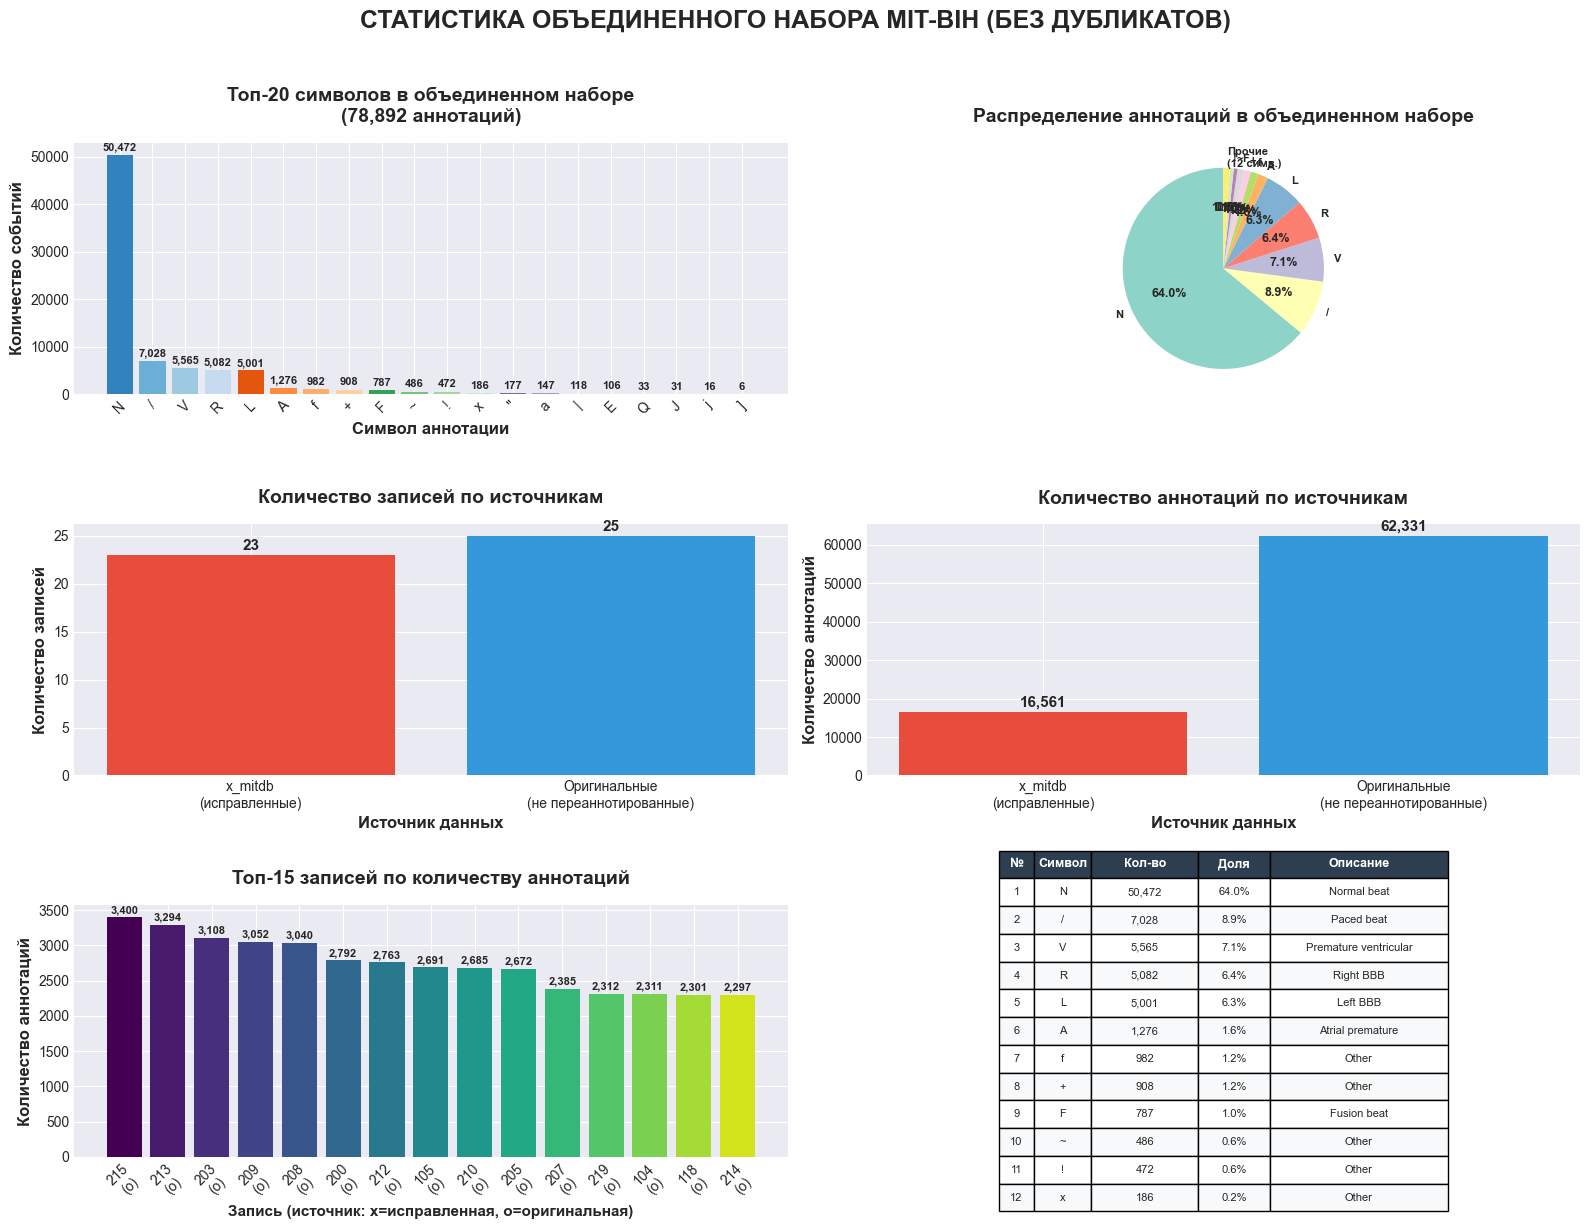


ДЕТАЛЬНАЯ СТАТИСТИКА ОБЪЕДИНЕННОГО НАБОРА:

ОБЩАЯ СТАТИСТИКА:
  Всего уникальных записей: 48
    • Исправленные (x_mitdb): 23 записей
    • Оригинальные: 25 записей
  Всего аннотаций: 78,892
    • Из исправленных записей: 16,561
    • Из оригинальных записей: 62,331
  Уникальных типов аннотаций: 23

ИСПРАВЛЕННЫЕ ЗАПИСИ (из x_mitdb):
  Всего: 23 записей
  Список: 108, 109, 111, 112, 113, 114, 115, 116, 117, 121, 122, 123, 124, 220, 221, 222, 223, 228, 230, 231, 232, 233, 234

ТОП-15 САМЫХ ЧАСТЫХ СИМВОЛОВ:
------------------------------------------------------------
№   Символ Количество   Доля     Накоп. доля 
------------------------------------------------------------
1   N      50,472         64.0%        64.0%
2   /      7,028           8.9%        72.9%
3   V      5,565           7.1%        79.9%
4   R      5,082           6.4%        86.4%
5   L      5,001           6.3%        92.7%
6   A      1,276           1.6%        94.3%
7   f      982             1.2%        95.6%
8   + 

In [3]:
BASE_PATH, X_MITDB_PATH = get_mitbih_paths()

final_stats = find_and_load_all_annotations()

plot_final_statistics(final_stats)

analyze_sources_comparison(final_stats)

save_final_results(final_stats)

print("\n" + "=" * 80)
print("АНАЛИЗ УСПЕШНО ЗАВЕРШЕН!")
print("=" * 80)
print("\nИтоговый набор содержит:")
print(f"  • {final_stats['total_records']} уникальных записей")
print(f"  • {final_stats['total_annotations']:,} аннотаций")
print(f"  • {final_stats['unique_symbols_total']} уникальных типов символов")
print("\nПриоритет отдан исправленным аннотациям из x_mitdb.")